In [ ]:
# Start writing code here...
import pandas as pd
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [ ]:
original_df = pd.read_csv('/work/trips.csv')
header_df = pd.read_csv('/work/TripBulkReportTripsHeaders.csv')
trips_df = pd.concat([original_df,header_df])

In [ ]:
# header = list(pd.read_csv('/work/TripBulkReportTripsHeaders.csv',keep_default_na=True))
# header.append('Unnamed 31')
# header.append('Unnamed 32')
# trips_df = pd.read_csv('/work/trips_new.csv', keep_default_na=True, names=header)

In [ ]:
trips_df.head()


,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,Unnamed: 31,Unnamed: 32
0,a939d5d8c9b52b5265161bfa93054f0a,0006da8402c807c4be339cab03f9d498,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T20:19:31.000Z,3,2022-05-11T20:22:52.000Z,3,30.18252,-96.93443,...,1,NaN,NaN,America/Chicago,America/Chicago,NaN,2.313010e+16,2.313010e+16,NaN,NaN
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,NaN,NaN
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}"""


In [ ]:
trips_df.columns

Index(['TripId', 'DeviceId', 'ProviderId', 'Mode', 'StartDate', 'StartWDay',
       'EndDate', 'EndWDay', 'StartLocLat', 'StartLocLon', 'EndLocLat',
       'EndLocLon', 'GeospatialType', 'ProviderType', 'ProviderDrivingProfile',
       'VehicleWeightClass', 'ProbeSourceType', 'OriginZoneName',
       'DestinationZoneName', 'EndpointType', 'TripMeanSpeedKph',
       'TripMaxSpeedKph', 'TripDistanceMeters', 'MovementType', 'OriginCbg',
       'DestCbg', 'StartTimezone', 'EndTimezone', 'WaypointFreqSec', 'StartQk',
       'EndQk', 'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')

In [ ]:
number_of_dup = len(trips_df[trips_df.duplicated(subset=list(trips_df.columns).remove('TripId')) == True])
number_of_fort = len(trips_df[(trips_df['OriginZoneName']!='Buc-ee\'s Giddings TX')& (trips_df['DestinationZoneName']!='Buc-ee\'s Giddings TX')])

print('Number of rows in original data:', len(trips_df))
print('Number of data in Fort Carson : ',number_of_fort)
print('Number of duplicated rows : ',number_of_dup)

Number of rows in original data: 136880
Number of data in Fort Carson :  134373
Number of duplicated rows :  0


# Create geometry column

In [ ]:
trips_df = trips_df[(trips_df['OriginZoneName']!='Buc-ee\'s Giddings TX')& (trips_df['DestinationZoneName']!='Buc-ee\'s Giddings TX')]

# creating a geometry column 
trips_df['Startlocation'] = list(zip(trips_df.StartLocLat, trips_df.StartLocLon))
trips_df['Startlocation'] = trips_df['Startlocation'].apply(Point)

trips_df['Endlocation'] = list(zip(trips_df.EndLocLat, trips_df.EndLocLon))
trips_df['Endlocation'] = trips_df['Endlocation'].apply(Point)


# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(trips_df, crs=crs)



In [ ]:
gdf

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,Unnamed: 31,Unnamed: 32,Startlocation,Endlocation
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.27969 -104.52873),POINT (38.34004 -104.67292)
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.75461 -104.78828),POINT (38.74819 -104.78828)
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,NaN,NaN,POINT (38.67639 -104.70588),POINT (38.73319 -104.77867)
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}""",POINT (38.55622 -104.64958),POINT (38.2193 -104.6537)
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.34111 -104.6688),POINT (38.34111 -104.6688)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136875,f596a0e64aee400218af08f1fe062f00,fde57a577be8a6b11280afe54b7a316d,d07e70efcfab08731a97e7b91be644de,1,2022-05-15T12:06:51.000Z,7,2022-05-15T12:13:10.000Z,7,38.72784,-104.79240,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,NaN,NaN,POINT (38.72784 -104.7924),POINT (38.74819 -104.78416)
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}""",POINT (38.7439 -104.81025),POINT (38.68497 -104.78828)
136877,da5e09d92b2d249fd239f0b274db03be,feaeb132ae78d4deef849bc4e446f1bf,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T12:50:36.000Z,3,2022-05-11T13:15:26.000Z,3,38.88942,-104.81849,...,NaN,America/Denver,America/Denver,NaN,2.310100e+16,2.310120e+16,NaN,NaN,POINT (38.88942 -104.81849),POINT (38.70962 -104.78141)
136878,69b3ef353faf547fe0df086c8877d7a7,ff1d04718d95f9e983e7be84ee7b925b,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:15:18.000Z,3,2022-05-11T14:40:25.000Z,3,38.73426,-104.81025,...,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.73426 -104.81025),POINT (38.74926 -104.81025)


# DateTime Preprocess

In [ ]:
gdf['MST_start_datetime'] = pd.to_datetime(gdf['StartDate']).apply(lambda x:x.astimezone('MST'))
gdf['MST_end_datetime'] = pd.to_datetime(gdf['EndDate']).apply(lambda x:x.astimezone('MST'))

gdf['MST_start_date'] = gdf['MST_start_datetime'].apply(lambda x:x.date())
gdf['MST_start_time'] = gdf['MST_start_datetime'].apply(lambda x:x.time())

gdf['MST_end_date'] = gdf['MST_end_datetime'].apply(lambda x:x.date())
gdf['MST_end_time'] = gdf['MST_end_datetime'].apply(lambda x:x.time())

# Exclude Vehicle Type "Fleet"

In [ ]:
# exclude data whose ProviderType == Fleet
gdf = gdf[gdf['ProviderType']==1] 

In [ ]:
gdf.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,Unnamed: 31,Unnamed: 32,Startlocation,Endlocation,MST_start_datetime,MST_end_datetime,MST_start_date,MST_start_time,MST_end_date,MST_end_time
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.27969 -104.52873),POINT (38.34004 -104.67292),2022-05-14 14:07:54-07:00,2022-05-14 14:58:03-07:00,2022-05-14,14:07:54,2022-05-14,14:58:03
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.75461 -104.78828),POINT (38.74819 -104.78828),2022-05-13 14:40:44-07:00,2022-05-13 14:48:42-07:00,2022-05-13,14:40:44,2022-05-13,14:48:42
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,NaN,NaN,POINT (38.67639 -104.70588),POINT (38.73319 -104.77867),2022-05-11 16:37:31-07:00,2022-05-11 16:47:49-07:00,2022-05-11,16:37:31,2022-05-11,16:47:49
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}""",POINT (38.55622 -104.64958),POINT (38.2193 -104.6537),2022-05-11 17:14:40-07:00,2022-05-11 17:37:38-07:00,2022-05-11,17:14:40,2022-05-11,17:37:38
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}""",POINT (38.34111 -104.6688),POINT (38.34111 -104.6688),2022-05-14 13:10:10-07:00,2022-05-14 14:33:25-07:00,2022-05-14,13:10:10,2022-05-14,14:33:25


In [ ]:
# gdf.to_csv("updated_trip.csv", index = False)

# Create Separate Columns for Date &amp; Time

In [ ]:
# create df of start day, month, year 
startYear = list(pd.DatetimeIndex(gdf['MST_start_date']).year)
startMonth = list(pd.DatetimeIndex(gdf['MST_start_date']).month)
startDay = list(pd.DatetimeIndex(gdf['MST_start_date']).day)

# insert the start month, day, year column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+1), 'MST_start_month',startMonth)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+2), 'MST_start_day',startDay)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+3), 'MST_start_year',startYear)

# create df of start hour, minutes, and seconds
startHour = list(pd.DatetimeIndex(gdf['MST_start_datetime']).hour)
startMin = list(pd.DatetimeIndex(gdf['MST_start_datetime']).minute)
startSec = list(pd.DatetimeIndex(gdf['MST_start_datetime']).second)

# insert the start hour, minutes, seconds column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+1), 'MST_start_hour',startHour)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+2), 'MST_start_minute',startMin)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+3), 'MST_start_second',startSec)

# create df of end day, month, year 
endYear = list(pd.DatetimeIndex(gdf['MST_end_date']).year)
endMonth = list(pd.DatetimeIndex(gdf['MST_end_date']).month)
endDay = list(pd.DatetimeIndex(gdf['MST_end_date']).day)

# insert the start month, day, year column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+1), 'MST_end_month',endMonth)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+2), 'MST_end_day',endDay)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+3), 'MST_end_year',endYear)

# create df of end hour, minutes, and seconds
endHour = list(pd.DatetimeIndex(gdf['MST_end_datetime']).hour)
endMin = list(pd.DatetimeIndex(gdf['MST_end_datetime']).minute)
endSec = list(pd.DatetimeIndex(gdf['MST_end_datetime']).second)

# insert the start hour, minutes, seconds column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+1), 'MST_end_hour',endHour)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+2), 'MST_end_minute',endMin)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+3), 'MST_end_second',endSec)

gdf

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_minute,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,7,54,2022-05-14,5,14,2022,14:58:03,14,58,3
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,40,44,2022-05-13,5,13,2022,14:48:42,14,48,42
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,37,31,2022-05-11,5,11,2022,16:47:49,16,47,49
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,14,40,2022-05-11,5,11,2022,17:37:38,17,37,38
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,10,10,2022-05-14,5,14,2022,14:33:25,14,33,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136875,f596a0e64aee400218af08f1fe062f00,fde57a577be8a6b11280afe54b7a316d,d07e70efcfab08731a97e7b91be644de,1,2022-05-15T12:06:51.000Z,7,2022-05-15T12:13:10.000Z,7,38.72784,-104.79240,...,6,51,2022-05-15,5,15,2022,05:13:10,5,13,10
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,55,10,2022-05-09,5,9,2022,14:03:00,14,3,0
136877,da5e09d92b2d249fd239f0b274db03be,feaeb132ae78d4deef849bc4e446f1bf,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T12:50:36.000Z,3,2022-05-11T13:15:26.000Z,3,38.88942,-104.81849,...,50,36,2022-05-11,5,11,2022,06:15:26,6,15,26
136878,69b3ef353faf547fe0df086c8877d7a7,ff1d04718d95f9e983e7be84ee7b925b,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:15:18.000Z,3,2022-05-11T14:40:25.000Z,3,38.73426,-104.81025,...,15,18,2022-05-11,5,11,2022,07:40:25,7,40,25


In [ ]:
# gdf.to_csv("new_updated_trip_datetime.csv", index = False)

# Find Device Living/Work Area

In [ ]:
# show the number of trips of each device 
occur = gdf.groupby(['DeviceId']).size()
occur = occur.sort_values(ascending=False)
occur

DeviceId
70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
                                    ..
5c2fcec0520b960ecdeb168f1a8d5a6b     1
5c31552bf5a1b828a6ee2ed83befe84d     1
5c3456a48b6bcfccc423cd81d95b66fc     1
5c34fce528d5773151acc2f75af81476     1
fffea5a18f1a308cee147a3e9c726700     1
Length: 68188, dtype: int64

In [ ]:
# preprocess: remove the records with only 1 trip
# df_occur = pd.DataFrame(occur)
# df_occur.columns = ["num_trips"]
# df_joined = gdf.join(df_occur, on='DeviceId', how='right')
# gdf_rm = df_joined.copy()
# gdf_rm = df_joined[df_joined['num_trips'] > 1]
# #gdf_rm.drop('num_trips', axis = 1, inplace=True)
# gdf_rm

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,num_trips
3560,26a0feb00dec4ceb3ea2bcb83249397c,0f38377b674a05d3e686a692b1ad0571,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T14:26:42.000Z,3,2022-05-25T14:50:15.000Z,3,38.80493,-104.75944,...,42,2022-05-25,5,25,2022,07:50:15,7,50,15,27
4414,6a0d80ca70d651c3821129613f049bde,0f38377b674a05d3e686a692b1ad0571,74071a673307ca7459bcf75fbd024e09,1,2022-05-26T22:09:07.000Z,4,2022-05-26T22:11:30.000Z,4,38.73533,-104.77455,...,7,2022-05-26,5,26,2022,15:11:30,15,11,30,27
6959,87770c1897e7c532c476a720d47413d2,0f38377b674a05d3e686a692b1ad0571,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T22:01:00.000Z,3,2022-05-25T22:14:34.000Z,3,38.75140,-104.78828,...,0,2022-05-25,5,25,2022,15:14:34,15,14,34,27
7580,a81a349a62972289b91af308f24a1864,0f38377b674a05d3e686a692b1ad0571,74071a673307ca7459bcf75fbd024e09,0,2022-05-26T15:01:36.000Z,4,2022-05-26T15:46:37.000Z,4,38.75568,-104.80613,...,36,2022-05-26,5,26,2022,08:46:37,8,46,37,27
8474,8321b3edb9c4e660a2cab423a6bf78b3,0f38377b674a05d3e686a692b1ad0571,74071a673307ca7459bcf75fbd024e09,1,2022-05-26T12:34:58.000Z,4,2022-05-26T12:52:59.000Z,4,38.74926,-104.78965,...,58,2022-05-26,5,26,2022,05:52:59,5,52,59,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40441,80e45ed8b3fec7dc8572365ee70dc84e,e898eba35cb47747372bfb8e5db0f71d,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T12:06:03.000Z,3,2022-05-25T12:29:42.000Z,3,38.73855,-104.80339,...,3,2022-05-25,5,25,2022,05:29:42,5,29,42,2
17284,1459d484b7bb2419dbfc62bd3980c584,ff4231adf048a371c033f02667417e1d,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T19:41:43.000Z,3,2022-05-25T20:02:57.000Z,3,38.99197,-104.80613,...,43,2022-05-25,5,25,2022,13:02:57,13,2,57,2
20461,5dbf0602d5f3eb42cbf903aa3b3611f6,ff4231adf048a371c033f02667417e1d,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T15:49:38.000Z,3,2022-05-25T16:16:47.000Z,3,38.75140,-104.79240,...,38,2022-05-25,5,25,2022,09:16:47,9,16,47,2
14657,725e42d4fde0e6db01ea9e5132038546,27c1cb40fb7e994991e5213cf5398335,74071a673307ca7459bcf75fbd024e09,1,2022-05-25T22:08:32.000Z,3,2022-05-25T22:20:51.000Z,3,38.42723,-104.60975,...,32,2022-05-25,5,25,2022,15:20:51,15,20,51,2


# II: Separate data with only "II" type

In [ ]:
gdf_ii = gdf.loc[gdf['GeospatialType'] == 'II']

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_minute,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,40,44,2022-05-13,5,13,2022,14:48:42,14,48,42
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,10,10,2022-05-14,5,14,2022,14:33:25,14,33,25
8,be43cc069b8c2d3ef15bc1314eb77a8f,026d8464ea4b70ea68e6a20087c82391,d07e70efcfab08731a97e7b91be644de,1,2022-05-10T21:21:39.000Z,2,2022-05-10T21:35:46.000Z,2,38.39925,-104.70863,...,21,39,2022-05-10,5,10,2022,14:35:46,14,35,46
9,3662fdca8464823826fe3d2bbd427b54,02a6e7ebd01c0e39a1e4de58633620d1,26337353b7962f533d78c762373b3318,1,2022-05-11T22:35:21.000Z,3,2022-05-11T22:44:27.000Z,3,38.72248,-104.77867,...,35,21,2022-05-11,5,11,2022,15:44:27,15,44,27
11,846a8478a9c3bb8cdb2c88708b327753,02e06fbf79c45add7d58300b64b28bd2,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T22:48:05.000Z,4,2022-05-12T22:54:36.000Z,4,38.74605,-104.79377,...,48,5,2022-05-12,5,12,2022,15:54:36,15,54,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136870,8aef1b1850426c061dd5d1e472f4d1ad,fcad5a842f7f22b806e9227d65294271,74071a673307ca7459bcf75fbd024e09,0,2022-05-09T17:17:20.000Z,1,2022-05-09T17:36:05.000Z,1,38.72891,-104.80339,...,17,20,2022-05-09,5,9,2022,10:36:05,10,36,5
136873,c92b7b71efb1b5c3b58838649bf3cb5c,fd521d544b46a23524e5512f7048b547,d07e70efcfab08731a97e7b91be644de,1,2022-05-14T19:12:42.000Z,6,2022-05-14T19:20:10.000Z,6,38.31849,-104.62348,...,12,42,2022-05-14,5,14,2022,12:20:10,12,20,10
136874,991fd3dddbb039d8eca7fffe6d2bdf85,fdc30810d7800ab8ff6b65590630927c,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T14:04:18.000Z,1,2022-05-09T14:12:51.000Z,1,38.72784,-104.80339,...,4,18,2022-05-09,5,9,2022,07:12:51,7,12,51
136875,f596a0e64aee400218af08f1fe062f00,fde57a577be8a6b11280afe54b7a316d,d07e70efcfab08731a97e7b91be644de,1,2022-05-15T12:06:51.000Z,7,2022-05-15T12:13:10.000Z,7,38.72784,-104.79240,...,6,51,2022-05-15,5,15,2022,05:13:10,5,13,10


# Clustering on "II" Type Data

## Starting Point Clustering

In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ii[['StartLocLat', 'StartLocLon']]
end_features = gdf_ii[['EndLocLat', 'EndLocLon']]

In [ ]:
# do clustering
kmeans.fit(features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ii['cluster'] = labels

In [ ]:
gdf_ii

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,44,2022-05-13,5,13,2022,14:48:42,14,48,42,24
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,10,2022-05-14,5,14,2022,14:33:25,14,33,25,25
8,be43cc069b8c2d3ef15bc1314eb77a8f,026d8464ea4b70ea68e6a20087c82391,d07e70efcfab08731a97e7b91be644de,1,2022-05-10T21:21:39.000Z,2,2022-05-10T21:35:46.000Z,2,38.39925,-104.70863,...,39,2022-05-10,5,10,2022,14:35:46,14,35,46,13
9,3662fdca8464823826fe3d2bbd427b54,02a6e7ebd01c0e39a1e4de58633620d1,26337353b7962f533d78c762373b3318,1,2022-05-11T22:35:21.000Z,3,2022-05-11T22:44:27.000Z,3,38.72248,-104.77867,...,21,2022-05-11,5,11,2022,15:44:27,15,44,27,0
11,846a8478a9c3bb8cdb2c88708b327753,02e06fbf79c45add7d58300b64b28bd2,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T22:48:05.000Z,4,2022-05-12T22:54:36.000Z,4,38.74605,-104.79377,...,5,2022-05-12,5,12,2022,15:54:36,15,54,36,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136870,8aef1b1850426c061dd5d1e472f4d1ad,fcad5a842f7f22b806e9227d65294271,74071a673307ca7459bcf75fbd024e09,0,2022-05-09T17:17:20.000Z,1,2022-05-09T17:36:05.000Z,1,38.72891,-104.80339,...,20,2022-05-09,5,9,2022,10:36:05,10,36,5,7
136873,c92b7b71efb1b5c3b58838649bf3cb5c,fd521d544b46a23524e5512f7048b547,d07e70efcfab08731a97e7b91be644de,1,2022-05-14T19:12:42.000Z,6,2022-05-14T19:20:10.000Z,6,38.31849,-104.62348,...,42,2022-05-14,5,14,2022,12:20:10,12,20,10,3
136874,991fd3dddbb039d8eca7fffe6d2bdf85,fdc30810d7800ab8ff6b65590630927c,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T14:04:18.000Z,1,2022-05-09T14:12:51.000Z,1,38.72784,-104.80339,...,18,2022-05-09,5,9,2022,07:12:51,7,12,51,7
136875,f596a0e64aee400218af08f1fe062f00,fde57a577be8a6b11280afe54b7a316d,d07e70efcfab08731a97e7b91be644de,1,2022-05-15T12:06:51.000Z,7,2022-05-15T12:13:10.000Z,7,38.72784,-104.79240,...,51,2022-05-15,5,15,2022,05:13:10,5,13,10,17


In [ ]:
gdf_ii.to_csv("trips_ii.csv")

# II: Show Number of Trips By Cluster

In [ ]:
gdf_ii =  pd.read_csv('trips_ii.csv', index_col = 0)

In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ii.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

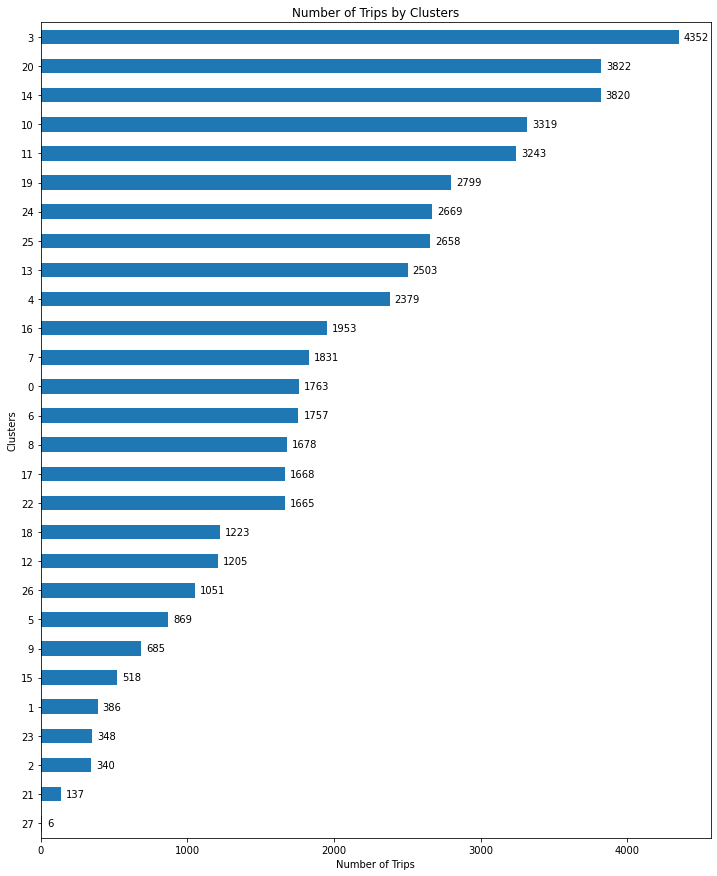

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ii.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      70e68ce6b66dd2052c188f2bd8ad0563       19         89
1      70e68ce6b66dd2052c188f2bd8ad0563        4          1
2      c6d52211ec83fb63badb38f323b9544e       25         68
3      c6d52211ec83fb63badb38f323b9544e       22          8
4      c6d52211ec83fb63badb38f323b9544e        2          2
...                                 ...      ...        ...
30100  8bb4fd0e00d8951491aeab47c91a4c53       17          1
30101  8b3d2f6904d5673d801c86b26d6682af       10          1
30102  8ae52720507f655f1b6c39bb813a7be9       26          1
30103  8a47a22ff73ff90cd09f490421155737        7          1
30104  fde57a577be8a6b11280afe54b7a316d       17          1

[30105 rows x 3 columns]


## End Point Clustering

In [ ]:
gdf_ii = gdf.loc[gdf['GeospatialType'] == 'II']

In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ii[['StartLocLat', 'StartLocLon']]
end_features = gdf_ii['EndLocLat', 'EndLocLon']

In [ ]:
# do clustering
kmeans.fit(end_features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ii['cluster'] = labels

In [ ]:
gdf_ii

In [ ]:
gdf_ii.to_csv("trips_ii.csv")

## II Endpoint: Show Number of Trips By Cluster

In [ ]:
gdf_ii =  pd.read_csv('trips_ii_end.csv', index_col = 0)

In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ii.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

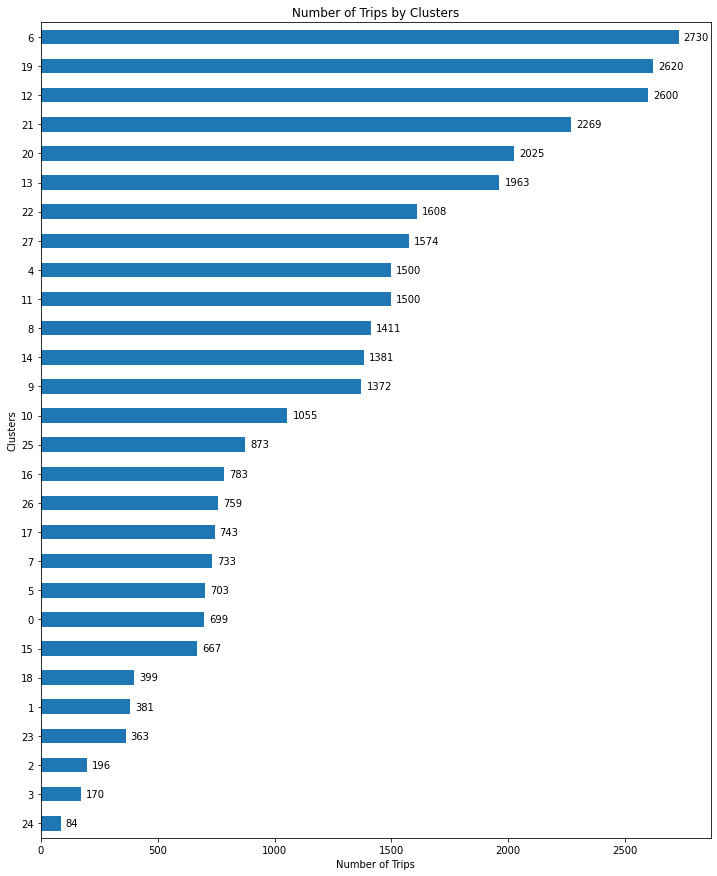

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ii.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      c6d52211ec83fb63badb38f323b9544e       11         52
1      c6d52211ec83fb63badb38f323b9544e        2          2
2      c6d52211ec83fb63badb38f323b9544e       25          1
3      70e68ce6b66dd2052c188f2bd8ad0563        0         50
4      74c4a0d6119702b6a7698cda4ba35aae        8         41
...                                 ...      ...        ...
21141  6b9e0697bf26af5137a67ce382490204       11          1
21142  718b4651a4bbf58b2c48d30e430675a4       20          1
21143  71b745ddbfdac8a53e7b905de37985d1       19          1
21144  76091e82f9be35bb46e2b89aa7d5c673       10          1
21145  771e3444fdffb8ed9c697e80ae6b83c7        6          1

[21146 rows x 3 columns]


In [ ]:
grouped_device_trips.head(40)

,DeviceId,cluster,tripcount
0,c6d52211ec83fb63badb38f323b9544e,11,52
1,c6d52211ec83fb63badb38f323b9544e,2,2
2,c6d52211ec83fb63badb38f323b9544e,25,1
3,70e68ce6b66dd2052c188f2bd8ad0563,0,50
4,74c4a0d6119702b6a7698cda4ba35aae,8,41
5,fdb8335a86289cc02c878d534acc64d6,27,40
6,fdb8335a86289cc02c878d534acc64d6,4,8
7,fdb8335a86289cc02c878d534acc64d6,6,3
8,fdb8335a86289cc02c878d534acc64d6,13,1
9,3de0769d66ec0c1d5af1c6932a7cb11b,0,39


# IE: Separate data with only "IE" type

## Starting Point

In [ ]:
gdf_ie = gdf.loc[gdf['GeospatialType'] == 'IE']

In [ ]:
gdf_ie.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_minute,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,14,40,2022-05-11,5,11,2022,17:37:38,17,37,38
18,5b6fcc41d1c2d30000474ebc6fd69747,056c77bdf0d1b647bc66e65995dda271,74071a673307ca7459bcf75fbd024e09,0,2022-05-10T22:09:05.000Z,2,2022-05-10T22:10:33.000Z,2,38.74712,-104.79652,...,9,5,2022-05-10,5,10,2022,15:10:33,15,10,33
27,a1ce59c0b10dd0ee776dfdd5304a2bdd,088e08f5102544fefd77a789d4362a67,74071a673307ca7459bcf75fbd024e09,0,2022-05-11T21:01:09.000Z,3,2022-05-11T21:08:04.000Z,3,38.73426,-104.74296,...,1,9,2022-05-11,5,11,2022,14:08:04,14,8,4
30,636c951ee30ae7c803ee4759d567f66f,0a538acfa3cee3bfe687a43e53c8e0cb,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T17:47:16.000Z,4,2022-05-12T18:21:53.000Z,4,38.74819,-104.79377,...,47,16,2022-05-12,5,12,2022,11:21:53,11,21,53
35,0dea36751de37bd4672c914fd95609e2,0b3c9800744f1aa32a12d585b2a67db3,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:14:39.000Z,3,2022-05-11T14:22:17.000Z,3,38.32711,-104.62760,...,14,39,2022-05-11,5,11,2022,07:22:17,7,22,17


In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ie[['StartLocLat', 'StartLocLon']]
end_features = gdf_ie[['EndLocLat', 'EndLocLon']]

In [ ]:
# do clustering
kmeans.fit(features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ie['cluster'] = labels

In [ ]:
gdf_ie

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,40,2022-05-11,5,11,2022,17:37:38,17,37,38,26
18,5b6fcc41d1c2d30000474ebc6fd69747,056c77bdf0d1b647bc66e65995dda271,74071a673307ca7459bcf75fbd024e09,0,2022-05-10T22:09:05.000Z,2,2022-05-10T22:10:33.000Z,2,38.74712,-104.79652,...,5,2022-05-10,5,10,2022,15:10:33,15,10,33,7
27,a1ce59c0b10dd0ee776dfdd5304a2bdd,088e08f5102544fefd77a789d4362a67,74071a673307ca7459bcf75fbd024e09,0,2022-05-11T21:01:09.000Z,3,2022-05-11T21:08:04.000Z,3,38.73426,-104.74296,...,9,2022-05-11,5,11,2022,14:08:04,14,8,4,22
30,636c951ee30ae7c803ee4759d567f66f,0a538acfa3cee3bfe687a43e53c8e0cb,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T17:47:16.000Z,4,2022-05-12T18:21:53.000Z,4,38.74819,-104.79377,...,16,2022-05-12,5,12,2022,11:21:53,11,21,53,7
35,0dea36751de37bd4672c914fd95609e2,0b3c9800744f1aa32a12d585b2a67db3,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:14:39.000Z,3,2022-05-11T14:22:17.000Z,3,38.32711,-104.62760,...,39,2022-05-11,5,11,2022,07:22:17,7,22,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136860,03f659cf75e431438022f51ce17214ac,f854741db3a3bb74fb356b9cd98c5f28,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T22:49:10.000Z,1,2022-05-09T22:56:20.000Z,1,38.76318,-104.78691,...,10,2022-05-09,5,9,2022,15:56:20,15,56,20,24
136863,32082364859a10a1493cbfc4f826cb2b,f901b9848ff865d98c5846c6d3cb427c,74071a673307ca7459bcf75fbd024e09,0,2022-05-14T18:36:32.000Z,6,2022-05-14T18:43:50.000Z,6,38.31526,-104.64134,...,32,2022-05-14,5,14,2022,11:43:50,11,43,50,11
136865,e44911f42d40c3e3f8b15d1b17206588,fa95a68b6ffc2447c483cd43a5a2bbee,26337353b7962f533d78c762373b3318,1,2022-05-12T14:15:00.000Z,4,2022-05-12T14:39:28.000Z,4,38.57447,-104.68254,...,0,2022-05-12,5,12,2022,07:39:28,7,39,28,14
136872,b12fa813729a4675ca32306483527c8f,fd1a64b3749e1b29e94838fd8828a92a,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T14:16:17.000Z,2,2022-05-10T14:48:45.000Z,2,38.72784,-104.77317,...,17,2022-05-10,5,10,2022,07:48:45,7,48,45,8


In [ ]:
print(gdf_ie.shape)

(37332, 54)


In [ ]:
gdf_ie.to_csv("trips_ie_start.csv")

## IE: Show Number of Trips By Clusters

In [ ]:
gdf_ie_start =  pd.read_csv('trips_ie_start.csv', index_col = 0)

In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ie_start.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

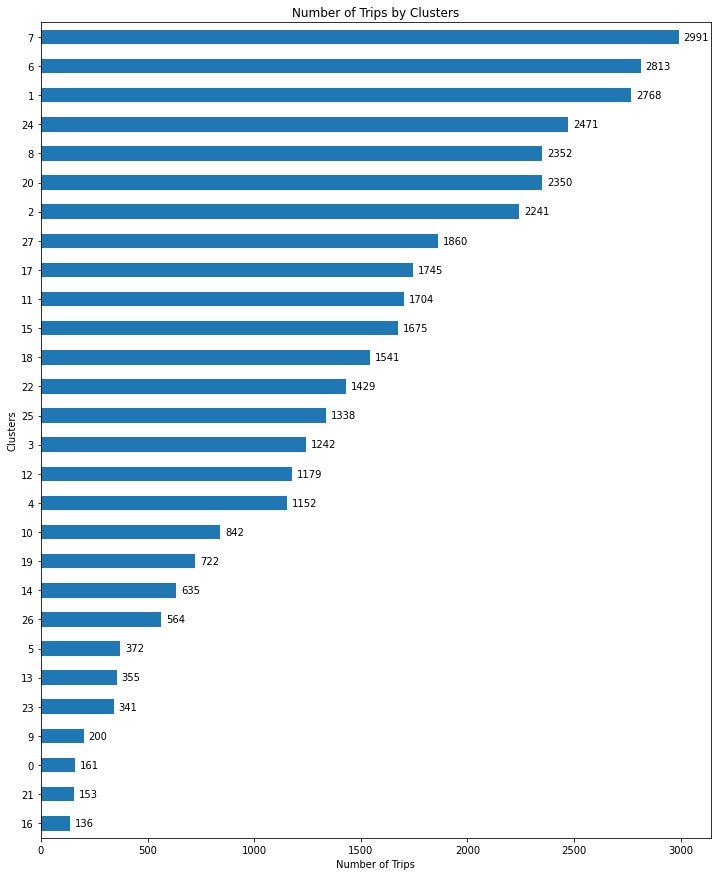

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ie_start.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      ae764fb8a25ed7e8e7a2418a9cd283a3        7         23
1      e670c392ca1a7d06f3a830a44d351ea2        1         20
2      4463db876cfb9492daaac5b440b07e8c       24         19
3      a949595ce57a2dac11db46ee171112a4        1         18
4      a949595ce57a2dac11db46ee171112a4       17          1
...                                 ...      ...        ...
29573  f1dc9c3b83f2691a51f36ba3b16ba445       12          1
29574  f06714f516ef684d5ac30db4e9cdcd42        3          1
29575  f02de152cb41bc3a6e05856027bb4c9e       27          1
29576  e548711579f30ed49f96185822a1598d        1          1
29577  e4ecc2cfa94532a1dcf9414279fe8dfd       18          1

[29578 rows x 3 columns]


In [ ]:
grouped_device_trips.head(40)

,DeviceId,cluster,tripcount
0,ae764fb8a25ed7e8e7a2418a9cd283a3,7,23
1,e670c392ca1a7d06f3a830a44d351ea2,1,20
2,4463db876cfb9492daaac5b440b07e8c,24,19
3,a949595ce57a2dac11db46ee171112a4,1,18
4,a949595ce57a2dac11db46ee171112a4,17,1
5,3414f4526779d6f266908ad1e4ff0123,1,18
6,3414f4526779d6f266908ad1e4ff0123,17,2
7,6eff0312c1ddd0cf96a387947c3194ab,24,17
8,67406a5b73ed2f6b347871d0911e8088,18,16
9,67406a5b73ed2f6b347871d0911e8088,4,5


## IE: End Point

In [ ]:
gdf_ie = gdf.loc[gdf['GeospatialType'] == 'IE']

In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ie[['StartLocLat', 'StartLocLon']]
end_features = gdf_ie[['EndLocLat', 'EndLocLon']]

In [ ]:
# do clustering
kmeans.fit(end_features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ie['cluster'] = labels

In [ ]:
gdf_ie

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,40,2022-05-11,5,11,2022,17:37:38,17,37,38,9
18,5b6fcc41d1c2d30000474ebc6fd69747,056c77bdf0d1b647bc66e65995dda271,74071a673307ca7459bcf75fbd024e09,0,2022-05-10T22:09:05.000Z,2,2022-05-10T22:10:33.000Z,2,38.74712,-104.79652,...,5,2022-05-10,5,10,2022,15:10:33,15,10,33,3
27,a1ce59c0b10dd0ee776dfdd5304a2bdd,088e08f5102544fefd77a789d4362a67,74071a673307ca7459bcf75fbd024e09,0,2022-05-11T21:01:09.000Z,3,2022-05-11T21:08:04.000Z,3,38.73426,-104.74296,...,9,2022-05-11,5,11,2022,14:08:04,14,8,4,16
30,636c951ee30ae7c803ee4759d567f66f,0a538acfa3cee3bfe687a43e53c8e0cb,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T17:47:16.000Z,4,2022-05-12T18:21:53.000Z,4,38.74819,-104.79377,...,16,2022-05-12,5,12,2022,11:21:53,11,21,53,8
35,0dea36751de37bd4672c914fd95609e2,0b3c9800744f1aa32a12d585b2a67db3,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:14:39.000Z,3,2022-05-11T14:22:17.000Z,3,38.32711,-104.62760,...,39,2022-05-11,5,11,2022,07:22:17,7,22,17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136860,03f659cf75e431438022f51ce17214ac,f854741db3a3bb74fb356b9cd98c5f28,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T22:49:10.000Z,1,2022-05-09T22:56:20.000Z,1,38.76318,-104.78691,...,10,2022-05-09,5,9,2022,15:56:20,15,56,20,26
136863,32082364859a10a1493cbfc4f826cb2b,f901b9848ff865d98c5846c6d3cb427c,74071a673307ca7459bcf75fbd024e09,0,2022-05-14T18:36:32.000Z,6,2022-05-14T18:43:50.000Z,6,38.31526,-104.64134,...,32,2022-05-14,5,14,2022,11:43:50,11,43,50,14
136865,e44911f42d40c3e3f8b15d1b17206588,fa95a68b6ffc2447c483cd43a5a2bbee,26337353b7962f533d78c762373b3318,1,2022-05-12T14:15:00.000Z,4,2022-05-12T14:39:28.000Z,4,38.57447,-104.68254,...,0,2022-05-12,5,12,2022,07:39:28,7,39,28,16
136872,b12fa813729a4675ca32306483527c8f,fd1a64b3749e1b29e94838fd8828a92a,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T14:16:17.000Z,2,2022-05-10T14:48:45.000Z,2,38.72784,-104.77317,...,17,2022-05-10,5,10,2022,07:48:45,7,48,45,0


In [ ]:
gdf_ie.to_csv("trips_ie_end.csv")

## IE: Endpoints: Show the Number of Trips by Cluster

In [ ]:
gdf_ie_end = pd.read_csv("trips_ie_end.csv",index_col=0)

In [ ]:
gdf_ie_end

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,40,2022-05-11,5,11,2022,17:37:38,17,37,38,9
18,5b6fcc41d1c2d30000474ebc6fd69747,056c77bdf0d1b647bc66e65995dda271,74071a673307ca7459bcf75fbd024e09,0,2022-05-10T22:09:05.000Z,2,2022-05-10T22:10:33.000Z,2,38.74712,-104.79652,...,5,2022-05-10,5,10,2022,15:10:33,15,10,33,3
27,a1ce59c0b10dd0ee776dfdd5304a2bdd,088e08f5102544fefd77a789d4362a67,74071a673307ca7459bcf75fbd024e09,0,2022-05-11T21:01:09.000Z,3,2022-05-11T21:08:04.000Z,3,38.73426,-104.74296,...,9,2022-05-11,5,11,2022,14:08:04,14,8,4,16
30,636c951ee30ae7c803ee4759d567f66f,0a538acfa3cee3bfe687a43e53c8e0cb,d07e70efcfab08731a97e7b91be644de,1,2022-05-12T17:47:16.000Z,4,2022-05-12T18:21:53.000Z,4,38.74819,-104.79377,...,16,2022-05-12,5,12,2022,11:21:53,11,21,53,8
35,0dea36751de37bd4672c914fd95609e2,0b3c9800744f1aa32a12d585b2a67db3,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T14:14:39.000Z,3,2022-05-11T14:22:17.000Z,3,38.32711,-104.62760,...,39,2022-05-11,5,11,2022,07:22:17,7,22,17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136860,03f659cf75e431438022f51ce17214ac,f854741db3a3bb74fb356b9cd98c5f28,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T22:49:10.000Z,1,2022-05-09T22:56:20.000Z,1,38.76318,-104.78691,...,10,2022-05-09,5,9,2022,15:56:20,15,56,20,26
136863,32082364859a10a1493cbfc4f826cb2b,f901b9848ff865d98c5846c6d3cb427c,74071a673307ca7459bcf75fbd024e09,0,2022-05-14T18:36:32.000Z,6,2022-05-14T18:43:50.000Z,6,38.31526,-104.64134,...,32,2022-05-14,5,14,2022,11:43:50,11,43,50,14
136865,e44911f42d40c3e3f8b15d1b17206588,fa95a68b6ffc2447c483cd43a5a2bbee,26337353b7962f533d78c762373b3318,1,2022-05-12T14:15:00.000Z,4,2022-05-12T14:39:28.000Z,4,38.57447,-104.68254,...,0,2022-05-12,5,12,2022,07:39:28,7,39,28,16
136872,b12fa813729a4675ca32306483527c8f,fd1a64b3749e1b29e94838fd8828a92a,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T14:16:17.000Z,2,2022-05-10T14:48:45.000Z,2,38.72784,-104.77317,...,17,2022-05-10,5,10,2022,07:48:45,7,48,45,0


In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ie_end.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

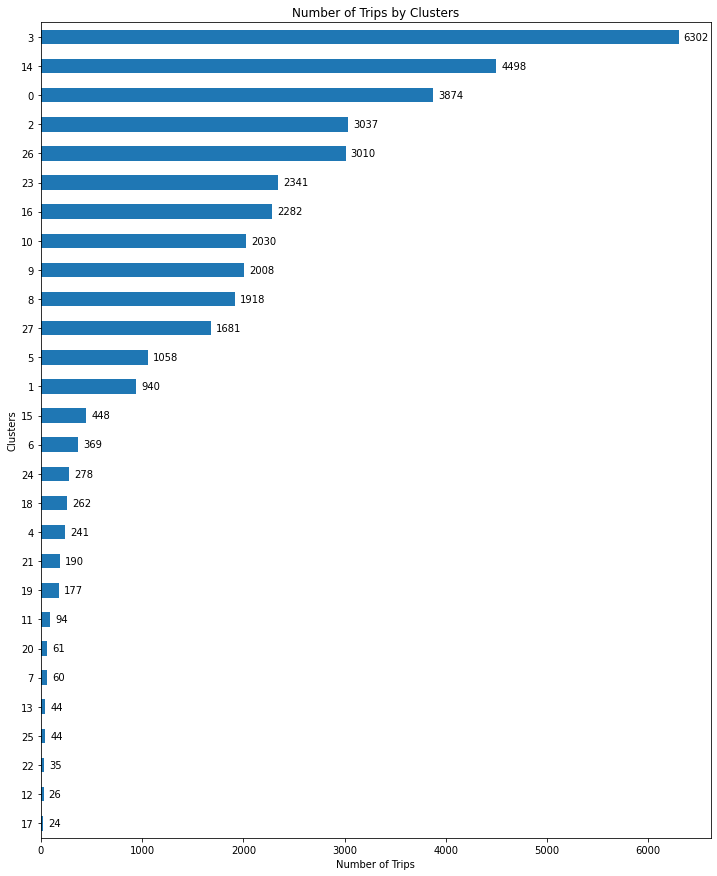

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ie_end.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      e670c392ca1a7d06f3a830a44d351ea2       23         18
1      e670c392ca1a7d06f3a830a44d351ea2       14          2
2      3414f4526779d6f266908ad1e4ff0123       23         17
3      3414f4526779d6f266908ad1e4ff0123       14          3
4      a949595ce57a2dac11db46ee171112a4       23         15
...                                 ...      ...        ...
29804  110c02e45f5f323b60a278ce1c273645        8          1
29805  10e6623f64dbee80f976e6f8ae7c8c10        9          1
29806  0c621f7ede9f8a164405c42c71b1ba13        3          1
29807  0b068f477aa4075bd3d1fe8a7b7fde55       10          1
29808  fa95a68b6ffc2447c483cd43a5a2bbee       16          1

[29809 rows x 3 columns]


In [ ]:
grouped_device_trips.head(40)

,DeviceId,cluster,tripcount
0,e670c392ca1a7d06f3a830a44d351ea2,23,18
1,e670c392ca1a7d06f3a830a44d351ea2,14,2
2,3414f4526779d6f266908ad1e4ff0123,23,17
3,3414f4526779d6f266908ad1e4ff0123,14,3
4,a949595ce57a2dac11db46ee171112a4,23,15
5,a949595ce57a2dac11db46ee171112a4,14,4
6,ae764fb8a25ed7e8e7a2418a9cd283a3,0,15
7,ae764fb8a25ed7e8e7a2418a9cd283a3,26,2
8,ae764fb8a25ed7e8e7a2418a9cd283a3,3,2
9,ae764fb8a25ed7e8e7a2418a9cd283a3,16,2


# EI: Separate Data with Only "EI" Type

## EI: Starting Point

In [ ]:
gdf_ei = gdf.loc[gdf['GeospatialType'] == 'EI']

In [ ]:
gdf_ei

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_minute,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,7,54,2022-05-14,5,14,2022,14:58:03,14,58,3
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,37,31,2022-05-11,5,11,2022,16:47:49,16,47,49
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,50,59,2022-05-14,5,14,2022,13:23:37,13,23,37
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,5,58,2022-05-10,5,10,2022,15:18:30,15,18,30
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,38,30,2022-05-12,5,12,2022,10:55:56,10,55,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136861,3ad8103ed637d49870f78813d1713409,f887adf9debe9666391f7ef2c9520ea8,d07e70efcfab08731a97e7b91be644de,1,2022-05-13T22:58:23.000Z,5,2022-05-13T23:21:45.000Z,5,38.23008,-104.61250,...,58,23,2022-05-13,5,13,2022,16:21:45,16,21,45
136867,2bef5a4bd4b2ed290dbfc920ad4d3ec5,fb70ba08ccf0e9ed7a667c879ce52596,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T13:55:38.000Z,4,2022-05-12T14:10:28.000Z,4,38.72355,-104.69902,...,55,38,2022-05-12,5,12,2022,07:10:28,7,10,28
136869,a3ee54466b74e289b5b008fe25f22f89,fc9b38462b967aaefcee78bbb8d8dd60,74071a673307ca7459bcf75fbd024e09,1,2022-05-13T18:43:11.000Z,5,2022-05-13T19:13:11.000Z,5,38.25166,-104.60838,...,43,11,2022-05-13,5,13,2022,12:13:11,12,13,11
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,55,10,2022-05-09,5,9,2022,14:03:00,14,3,0


In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ei[['StartLocLat', 'StartLocLon']]
end_features = gdf_ei[['EndLocLat', 'EndLocLon']]

In [ ]:
# do clustering
kmeans.fit(features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ei['cluster'] = labels

In [ ]:
gdf_ei

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,54,2022-05-14,5,14,2022,14:58:03,14,58,3,26
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,31,2022-05-11,5,11,2022,16:47:49,16,47,49,13
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,59,2022-05-14,5,14,2022,13:23:37,13,23,37,14
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,58,2022-05-10,5,10,2022,15:18:30,15,18,30,26
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,30,2022-05-12,5,12,2022,10:55:56,10,55,56,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136861,3ad8103ed637d49870f78813d1713409,f887adf9debe9666391f7ef2c9520ea8,d07e70efcfab08731a97e7b91be644de,1,2022-05-13T22:58:23.000Z,5,2022-05-13T23:21:45.000Z,5,38.23008,-104.61250,...,23,2022-05-13,5,13,2022,16:21:45,16,21,45,26
136867,2bef5a4bd4b2ed290dbfc920ad4d3ec5,fb70ba08ccf0e9ed7a667c879ce52596,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T13:55:38.000Z,4,2022-05-12T14:10:28.000Z,4,38.72355,-104.69902,...,38,2022-05-12,5,12,2022,07:10:28,7,10,28,16
136869,a3ee54466b74e289b5b008fe25f22f89,fc9b38462b967aaefcee78bbb8d8dd60,74071a673307ca7459bcf75fbd024e09,1,2022-05-13T18:43:11.000Z,5,2022-05-13T19:13:11.000Z,5,38.25166,-104.60838,...,11,2022-05-13,5,13,2022,12:13:11,12,13,11,26
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,10,2022-05-09,5,9,2022,14:03:00,14,3,0,10


In [ ]:
gdf_ei.to_csv("trips_ei_start.csv")

## EI: Starting Point: Show the Number of Trips by Cluster

In [ ]:
gdf_ei_start =  pd.read_csv('trips_ei_start.csv', index_col = 0)

In [ ]:
gdf_ei_start

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,54,2022-05-14,5,14,2022,14:58:03,14,58,3,26
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,31,2022-05-11,5,11,2022,16:47:49,16,47,49,13
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,59,2022-05-14,5,14,2022,13:23:37,13,23,37,14
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,58,2022-05-10,5,10,2022,15:18:30,15,18,30,26
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,30,2022-05-12,5,12,2022,10:55:56,10,55,56,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136861,3ad8103ed637d49870f78813d1713409,f887adf9debe9666391f7ef2c9520ea8,d07e70efcfab08731a97e7b91be644de,1,2022-05-13T22:58:23.000Z,5,2022-05-13T23:21:45.000Z,5,38.23008,-104.61250,...,23,2022-05-13,5,13,2022,16:21:45,16,21,45,26
136867,2bef5a4bd4b2ed290dbfc920ad4d3ec5,fb70ba08ccf0e9ed7a667c879ce52596,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T13:55:38.000Z,4,2022-05-12T14:10:28.000Z,4,38.72355,-104.69902,...,38,2022-05-12,5,12,2022,07:10:28,7,10,28,16
136869,a3ee54466b74e289b5b008fe25f22f89,fc9b38462b967aaefcee78bbb8d8dd60,74071a673307ca7459bcf75fbd024e09,1,2022-05-13T18:43:11.000Z,5,2022-05-13T19:13:11.000Z,5,38.25166,-104.60838,...,11,2022-05-13,5,13,2022,12:13:11,12,13,11,26
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,10,2022-05-09,5,9,2022,14:03:00,14,3,0,10


In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ei_start.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

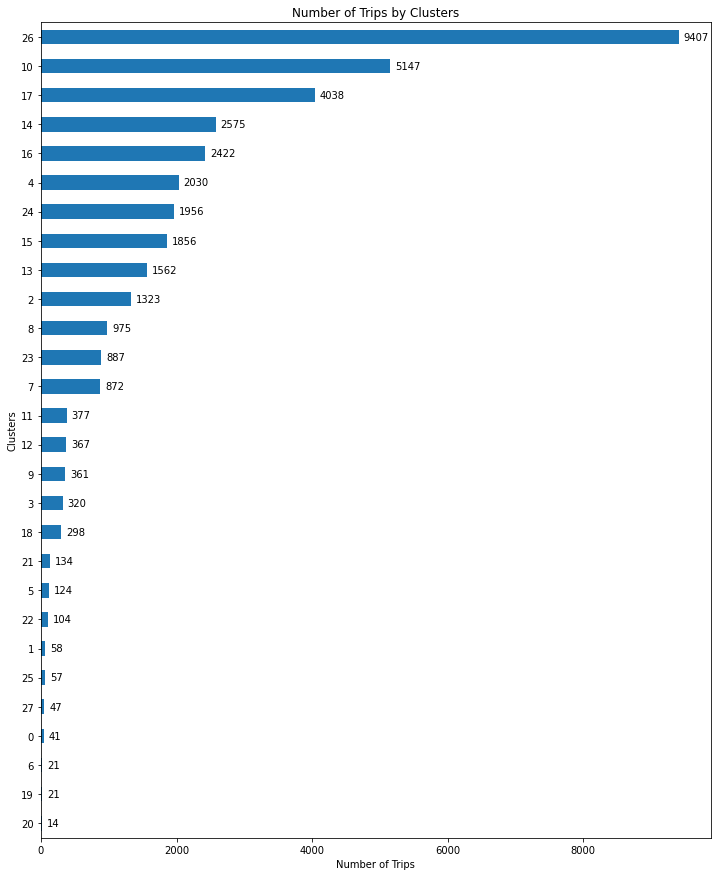

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ei_start.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      81ea12fcea22ed0c73261c410fdf3f2f       26         18
1      e670c392ca1a7d06f3a830a44d351ea2       26         18
2      c81ed8560baba8e52c8551254675c339       13         16
3      3414f4526779d6f266908ad1e4ff0123       26         15
4      502a2843e66df9e6cac7593003076e8b       16         15
...                                 ...      ...        ...
28935  3ce394d2c57bbd8bc836c794c7daeb57       17          1
28936  3586e7fb098f382c4481f0e8f1d6aa69       26          1
28937  351a92d89946d8daf573b212511b96d4       26          1
28938  338f036dc3c8ec269a9cb522244b0c48        5          1
28939  feaeb132ae78d4deef849bc4e446f1bf       24          1

[28940 rows x 3 columns]


## EI: End Point

In [ ]:
gdf_ei = gdf.loc[gdf['GeospatialType'] == 'EI']

In [ ]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=28,
    n_init=10,
    max_iter=300,
    random_state=42
)
features = gdf_ei[['StartLocLat', 'StartLocLon']]
end_features = gdf_ei[['EndLocLat', 'EndLocLon']]

In [ ]:
# do clustering
kmeans.fit(end_features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf_ei['cluster'] = labels

In [ ]:
gdf_ei

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,54,2022-05-14,5,14,2022,14:58:03,14,58,3,19
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,31,2022-05-11,5,11,2022,16:47:49,16,47,49,27
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,59,2022-05-14,5,14,2022,13:23:37,13,23,37,10
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,58,2022-05-10,5,10,2022,15:18:30,15,18,30,8
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,30,2022-05-12,5,12,2022,10:55:56,10,55,56,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136861,3ad8103ed637d49870f78813d1713409,f887adf9debe9666391f7ef2c9520ea8,d07e70efcfab08731a97e7b91be644de,1,2022-05-13T22:58:23.000Z,5,2022-05-13T23:21:45.000Z,5,38.23008,-104.61250,...,23,2022-05-13,5,13,2022,16:21:45,16,21,45,5
136867,2bef5a4bd4b2ed290dbfc920ad4d3ec5,fb70ba08ccf0e9ed7a667c879ce52596,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T13:55:38.000Z,4,2022-05-12T14:10:28.000Z,4,38.72355,-104.69902,...,38,2022-05-12,5,12,2022,07:10:28,7,10,28,11
136869,a3ee54466b74e289b5b008fe25f22f89,fc9b38462b967aaefcee78bbb8d8dd60,74071a673307ca7459bcf75fbd024e09,1,2022-05-13T18:43:11.000Z,5,2022-05-13T19:13:11.000Z,5,38.25166,-104.60838,...,11,2022-05-13,5,13,2022,12:13:11,12,13,11,12
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,10,2022-05-09,5,9,2022,14:03:00,14,3,0,16


In [ ]:
gdf_ei.to_csv("trips_ei_end.csv")

## EI: End Point: Show the Number of Trips by Clusters

In [ ]:
gdf_ei_end = pd.read_csv("trips_ei_end.csv",index_col=0)

In [ ]:
gdf_ei_end

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,54,2022-05-14,5,14,2022,14:58:03,14,58,3,19
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,31,2022-05-11,5,11,2022,16:47:49,16,47,49,27
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,59,2022-05-14,5,14,2022,13:23:37,13,23,37,10
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,58,2022-05-10,5,10,2022,15:18:30,15,18,30,8
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,30,2022-05-12,5,12,2022,10:55:56,10,55,56,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136861,3ad8103ed637d49870f78813d1713409,f887adf9debe9666391f7ef2c9520ea8,d07e70efcfab08731a97e7b91be644de,1,2022-05-13T22:58:23.000Z,5,2022-05-13T23:21:45.000Z,5,38.23008,-104.61250,...,23,2022-05-13,5,13,2022,16:21:45,16,21,45,5
136867,2bef5a4bd4b2ed290dbfc920ad4d3ec5,fb70ba08ccf0e9ed7a667c879ce52596,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T13:55:38.000Z,4,2022-05-12T14:10:28.000Z,4,38.72355,-104.69902,...,38,2022-05-12,5,12,2022,07:10:28,7,10,28,11
136869,a3ee54466b74e289b5b008fe25f22f89,fc9b38462b967aaefcee78bbb8d8dd60,74071a673307ca7459bcf75fbd024e09,1,2022-05-13T18:43:11.000Z,5,2022-05-13T19:13:11.000Z,5,38.25166,-104.60838,...,11,2022-05-13,5,13,2022,12:13:11,12,13,11,12
136876,287afa157da0090a26a76dba10eb9938,fea7ac25a159079787120bb8e3e8d353,74071a673307ca7459bcf75fbd024e09,1,2022-05-09T20:55:10.000Z,1,2022-05-09T21:03:00.000Z,1,38.74390,-104.81025,...,10,2022-05-09,5,9,2022,14:03:00,14,3,0,16


In [ ]:
# display the number of mamber each clustering
_clusters = gdf_ei_end.groupby('cluster',as_index=False).agg(tripcount = ('TripId','count'))
sorted_clusters = _clusters.sort_values(by ='tripcount')

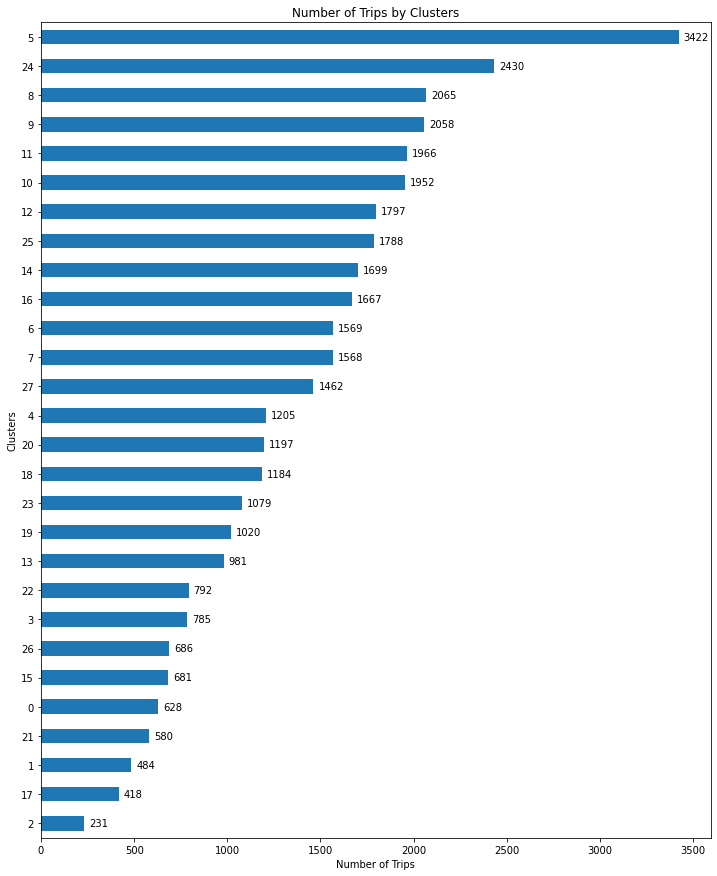

In [ ]:
#plt.rcParams['figure.figsize'] = [12, 15]
plt.figure(figsize=(12,15))
# Plot the figure.
cluster = list(sorted_clusters.index)
tripcount = sorted_clusters['tripcount']
# Plot the figure.
ax = tripcount.plot(kind='barh')
ax.set_title('Number of Trips by Clusters')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Clusters')
ax.set_yticklabels(cluster)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:d}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

#plt.savefig("image.png")

In [ ]:
device_cluster = gdf_ei_end.groupby(['DeviceId','cluster'],sort=False, as_index=False).agg(tripcount = ('TripId','count'))
device_cluster = device_cluster.sort_values(by=['tripcount'], ascending=False)
df_agg = device_cluster.groupby(['DeviceId','cluster']).agg({'tripcount':sum})
g = df_agg['tripcount'].groupby('DeviceId', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(3))
grouped_device_trips = device_cluster.groupby(["DeviceId"], sort=False).apply(lambda x: x.sort_values(["tripcount"], ascending = False)).reset_index(drop=True)
print(grouped_device_trips)

                               DeviceId  cluster  tripcount
0      4463db876cfb9492daaac5b440b07e8c        9         22
1      81ea12fcea22ed0c73261c410fdf3f2f       17         18
2      e670c392ca1a7d06f3a830a44d351ea2        5         18
3      69f010091805bb9580f43db6c55cde58        8         17
4      a4944281ee7f5bc8abccf97ad46750b0        5         17
...                                 ...      ...        ...
28456  f68bde88f730e0011311d3c6f6b14051        0          1
28457  f419da96dad52c17456fd489e9029c6f       11          1
28458  f374f6526145fd5166bfd72dbcbb865b       23          1
28459  f2bc3a715cf2dc041072816a3b1f8f4c       12          1
28460  feaeb132ae78d4deef849bc4e446f1bf       10          1

[28461 rows x 3 columns]


In [ ]:
gdf_ei_end.head(40)

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second,cluster
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,54,2022-05-14,5,14,2022,14:58:03,14,58,3,19
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,31,2022-05-11,5,11,2022,16:47:49,16,47,49,27
6,a26e4c1d7b458d26d63c5ac72f7fc9ed,01cef4ecca0480157a34c04c441a1dd8,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T19:50:59.000Z,6,2022-05-14T20:23:37.000Z,6,38.83810,-104.74708,...,59,2022-05-14,5,14,2022,13:23:37,13,23,37,10
7,81c2d21e0463caa30899a4ebcb6cdfcc,01fc33b299b4d8c0ddff10670e4b9d9d,74071a673307ca7459bcf75fbd024e09,1,2022-05-10T22:05:58.000Z,2,2022-05-10T22:18:30.000Z,2,38.30340,-104.60700,...,58,2022-05-10,5,10,2022,15:18:30,15,18,30,8
10,1bfc5f4df2ce22cbff2e61b7f544d6db,02b730b0de11084965d6a35d9ad9930e,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T17:38:30.000Z,4,2022-05-12T17:55:56.000Z,4,38.44767,-105.21537,...,30,2022-05-12,5,12,2022,10:55:56,10,55,56,18
12,30d99a0e70b25e8cce22d8714e935e6c,02e48b79e98f0b99e7c29fdcbd840265,74071a673307ca7459bcf75fbd024e09,1,2022-05-11T04:39:47.000Z,2,2022-05-11T04:53:10.000Z,2,38.32388,-104.70726,...,47,2022-05-10,5,10,2022,21:53:10,21,53,10,19
13,772fe9dd5c1740468861ef74e0748317,03e7612ed79df99e624679d9f67e26f2,74071a673307ca7459bcf75fbd024e09,3,2022-05-13T13:25:32.000Z,5,2022-05-13T13:41:44.000Z,5,38.78352,-104.73609,...,32,2022-05-13,5,13,2022,06:41:44,6,41,44,11
15,29235cb81476dabd36df5b51e1215857,044b4c391ff4beac0d87d6eefd0a3db1,26337353b7962f533d78c762373b3318,1,2022-05-12T14:36:45.000Z,4,2022-05-12T14:58:03.000Z,4,38.78888,-104.75257,...,45,2022-05-12,5,12,2022,07:58:03,7,58,3,27
17,97064f620a3ffac8c7dbd0acd828f33c,0508da0cd7c6ab825e0b6ba2b91ff0b3,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T11:23:47.000Z,3,2022-05-11T11:45:35.000Z,3,38.84666,-104.75120,...,47,2022-05-11,5,11,2022,04:45:35,4,45,35,20
20,95fafd07517ee667924fb60aff16820c,0606dd8014e4a3d2148062952664b2c8,74071a673307ca7459bcf75fbd024e09,1,2022-05-15T02:35:36.000Z,6,2022-05-15T03:58:18.000Z,6,38.70748,-104.69627,...,36,2022-05-14,5,14,2022,20:58:18,20,58,18,15


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9863cd21-6747-4678-bbdd-813e8a94296e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>